We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
pd.options.mode.chained_assignment = None
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Flight Fare EDA.

In [9]:
### DATA PREPARATION
flightfare = pd.read_excel('C:\\Users\\Shekhar Lamba\\Desktop\\Python\\Projects\\Flight\Data_Train.xlsx')

df = pd.DataFrame(flightfare)

df['Destination'] = df['Destination'].replace('New Delhi', 'Delhi')

df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format = '%d/%m/%Y')

df['Weekday_of_Journey'] = df['Date_of_Journey'].dt.weekday
df['Day_of_Journey'] = df['Date_of_Journey'].dt.day
df['Month_of_Journey'] = df['Date_of_Journey'].dt.month
df.drop(['Date_of_Journey'], axis = 1, inplace = True)

df['Weekend_Journey'] = np.where(df['Weekday_of_Journey'] >= 5, 1, 0)
df.drop(['Weekday_of_Journey'], axis = 1, inplace = True)

df['Dep_Hour'] = pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.hour
df['Dep_Mins'] = pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.minute
df.drop(['Dep_Time'], axis = 1, inplace = True)

df['Next_Day_Arrival'] = 0
row_range = range(0, len(df))
for row in row_range: 
    df['Next_Day_Arrival'][row] = np.where((len(df['Arrival_Time'][row]) > 5), 1, 0)

df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Mins'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop(['Arrival_Time'], axis = 1, inplace = True)

row_range = range(0, len(df))
for row in row_range:
    if(len(df['Duration'][row]) <= 3):
        if 'h' in df['Duration'][row]:
            df['Duration'][row] = df['Duration'][row] + ' 0m'
        elif 'm' in df['Duration'][row]:
            df['Duration'][row] = '0h ' + df['Duration'][row]

df['Duration_in_minutes'] = 0
row_range = range(0, len(df))
for row in row_range:
    df['Duration_in_minutes'][row] = (int(df['Duration'][row].split('h ')[0]) * 60) + int(df['Duration'][row].split('h ')[1].replace('m', ''))

df.drop(['Duration'], axis = 1, inplace = True)

df['Flight_Route'] = 0
x_values = range(0, len(df))
for x in x_values:
    route = str(df['Route'][x])
    stops = route.count('→')
    if (stops == 1):
        df['Flight_Route'][x] = 'Direct'
    else:
        df['Flight_Route'][x] = df['Route'][x]

top_routes = df['Flight_Route'].value_counts().index[:6]
df['Flight_Route'] = np.where(df['Flight_Route'].isin(top_routes), df['Flight_Route'], 'Other')

df.drop(['Route'], axis = 1, inplace = True)
df.drop(['Additional_Info'], axis = 1, inplace = True)

df['Weekend_Journey'] = df['Weekend_Journey'].astype('int64')

df = df.dropna()

num_vars = df.select_dtypes(include = ['int64'])
cat_vars = df.select_dtypes(include = ['object'])
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]
feature_names

pair = num_vars[['Price', 'Duration_in_minutes']]

for col in df.columns:
    if col in pair.columns:
        percentile = df[col].quantile([0.05, 0.95]).values
        df[col] = df[col].clip(lower = percentile[0], upper = percentile[1])

stops_mapper = {'non-stop': 0,
         '1 stop': 1,
         '2 stops': 2,
         '3 stops': 3,
         '4 stops': 4}
df['Total_Stops'] = df['Total_Stops'].replace(stops_mapper)

df['Flight_Route'] = df['Flight_Route'].replace(['DEL → BOM → COK', 'CCU → BOM → BLR', 'CCU → DEL → BLR', 'BLR → BOM → DEL',
                                                'DEL → HYD → COK'], ['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'])
df = df.rename(columns = {'Flight_Route': 'Route'})

df_final = pd.get_dummies(df, columns = ['Airline', 'Source', 'Destination', 'Route'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2.

In [10]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['Price'], axis = 1)
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 99)

We now go on to make a simple Random Forest model, which will serve as our baseline. We also tell our model to calculate the Out-of-Bag score which will later help us to get the Out-of-bag error. The oob error is the average error of the model in predicting the price for those data points which were left out during the process of bootstrapping while creating the random forest.

So, we build the model with _'oob_score'_ as true, fit it to the training data and use it to get predictions for the testing set. We then calculate the following metrics:

1. MAE: It stands for Mean Absolute Error. It is calculated by taking the mean of the absolute difference between the dependent variable values and their respective predicted values acquired from the model.
2. RMSE: It stands for Root Mean Squared Error. It is calculated by first taking the difference between the dependent variable values and their respective predicted values acquired from the model, then squaring each of them and taking the square root of their mean value. 
3. R-Squared: It is the proportion of variation in the dependent variable which is explained by the independent variables.

For a good model, the MAE and RMSE values should be as low as possible while the R-Squared value should be closer to 1.

In [28]:
### CREATING A BASELINE MODEL AND CALCULATING ESSENTIAL METRICS
model_rf = RandomForestRegressor(random_state = 99, oob_score = True, n_jobs = -1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_rf))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R-Squared: %f' % r2_score(y_test, y_pred_rf))
print('OOB Error: %f' % (1 - model_rf.oob_score_))

MAE: 1057.511831
RMSE: 1651.519001
R-Squared: 0.816486
OOB Error: 0.175993


We see that MAE is about 1057.5 and RMSE is about 1651.52 which seem quite high. R-Squared is about 0.81 which means that right now, about 81% of the variation in price of flight tickets can explained by the independent features. Also, the OOB error is about 0.18. Going forward, we shall try to improve these metrics.

In addition to these metrics, we shall also check if the errors are normally distributed. This is required for the error rates we are willing to accept when making decisions about the process. If the errors are not normal, incorrect decisions will be made more or less frequently than the stated confidence levels.

<Figure size 1152x864 with 0 Axes>

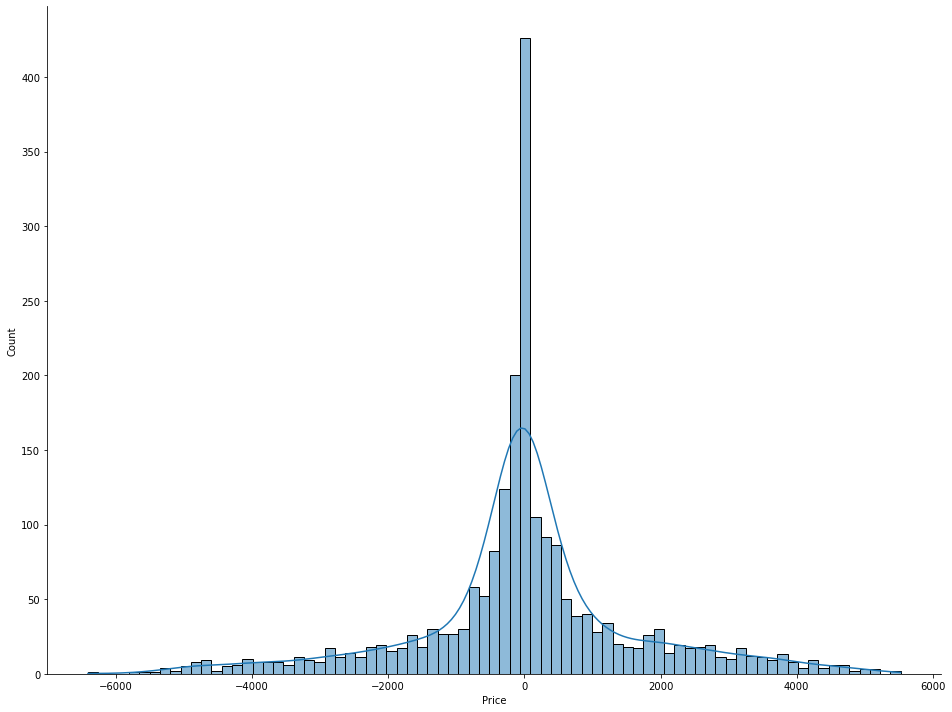

In [29]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_rf), height = 10, aspect = 8/6, kde = True)

The errors do not seem as normal as we want them to be, something we'll look to improve going forward.

Random Forest also allows us to look at the variables that it considers important to the final outcome.

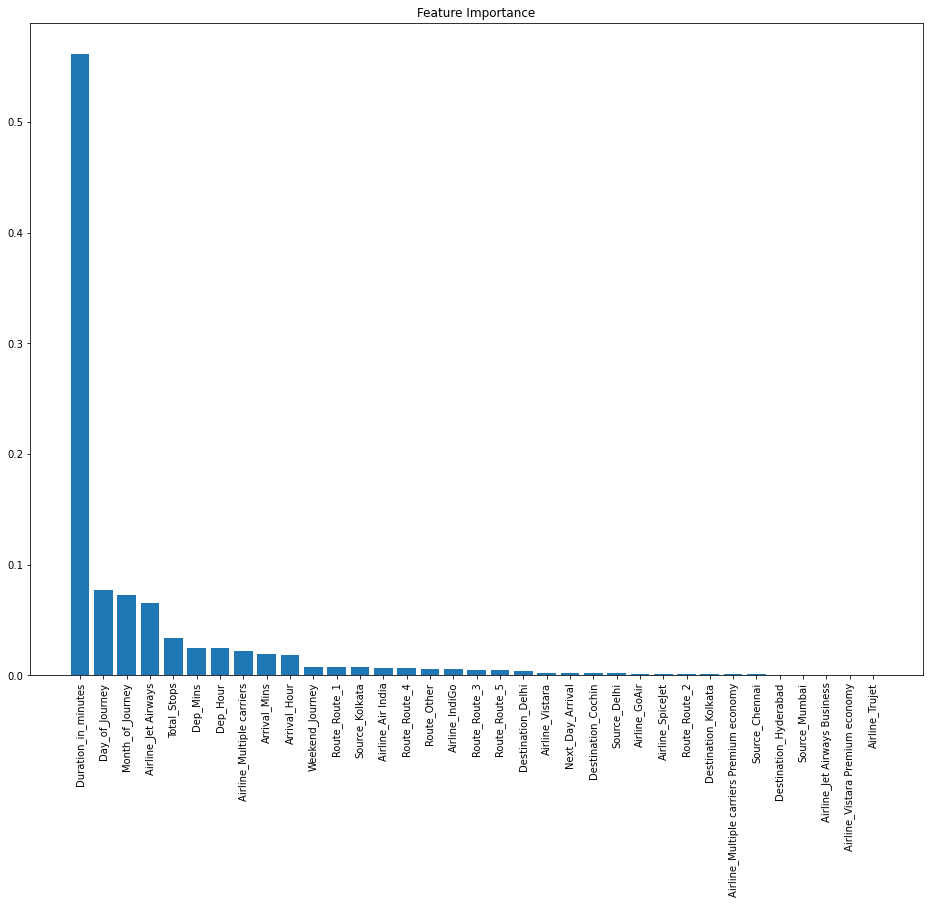

In [12]:
### PLOTTING FEATURE IMPORTANCE
importance = model_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We see that _'Duration_in_minutes'_ is considered to be very important. This may be due to the range of it's values being larger than others. _'Day_of_Journey'_, _'Month_of_Journey'_, _'Airline_Jet_Airways'_ and _'Total_Stops'_ are the other features considered significant in that particular order.


Next, we will try to further improve the model by tuning it's hyperparameters. For this, we shall use random search with 5 fold cross-validation across the possible values for the following hyperparameters:
1. n_estimators: the number of trees in the forest
2. max_depth: the maximum number of levels in each tree in the forest
3. max_features: the maximum number of features to be considered while making a tree
4. min_samples_leaf: the minimum number of samples required to consider a node as a leaf
5. min_samples_split: the minimum number of samples required to further split a node 

We will be using R-squared value as our scoring parameter.

In [21]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions = {
    'n_estimators': range(100, 1000, 50),
    'max_depth': range(3, 15),
    'max_features': range(5, 25),
    'min_samples_leaf': range(3, 20),
    'min_samples_split': range(3, 20)
}
rf = RandomForestRegressor(random_state = 99, oob_score = True, n_jobs = -1)
random_fit = RandomizedSearchCV(estimator = rf,
                               param_distributions = param_distributions,
                               cv = 5,
                               n_iter = 40,
                               random_state = 99,
                               verbose = 2,
                               n_jobs = -1)
random_fit.fit(X_train, y_train)
print(random_fit.best_params_)
print('Best score: %f' % random_fit.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  9.7min finished


{'n_estimators': 400, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 19, 'max_depth': 13}
Best score: 0.851844


In [22]:
param_distributions = {
    'n_estimators': range(350, 450, 20),
    'max_depth': [13],
    'max_features': range(5, 19),
    'min_samples_leaf': range(2, 5),
    'min_samples_split': [9]
}
rf = RandomForestRegressor(random_state = 99, oob_score = True, n_jobs = -1)
random_fit = RandomizedSearchCV(estimator = rf,
                               param_distributions = param_distributions,
                               cv = 5,
                               n_iter = 40,
                               random_state = 99,
                               verbose = 2,
                               n_jobs = -1)
random_fit.fit(X_train, y_train)
print(random_fit.best_params_)
print('Best score: %f' % random_fit.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.4min finished


{'n_estimators': 430, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 18, 'max_depth': 13}
Best score: 0.852349


Now, with these tuned hyperparameter values, we shall create our second model.

In [30]:
### CREATING THE IMPROVED MODEL AND CALCULATING ESSENTIAL METRICS
model_rf = RandomForestRegressor(random_state = 99,
                                 n_estimators = 430,
                                 min_samples_split = 9,
                                 min_samples_leaf = 2,
                                 max_features = 18,
                                 max_depth = 13,
                                 oob_score = True, 
                                 n_jobs = -1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_rf))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R-Squared: %f' % r2_score(y_test, y_pred_rf))
print('OOB Error: %f' % (1 - model_rf.oob_score_))

MAE: 1053.897195
RMSE: 1485.117590
R-Squared: 0.851603
OOB Error: 0.142482


We see that the MAE has reduced from about 1057.5 to about 1053.9; RMSE has also reduced to about 1485.12 from it's initial value of about 1651.52. The R-Squared value has increased from about 0.81 to almost 0.852 which means that currently, about 85.2% of the variation in price of flight tickets can explained by the independent features. Also, the OOB error has gone down from about 0.18 to about 0.14.

We can also plot the errors to see if they are normally distributed.

<Figure size 1152x864 with 0 Axes>

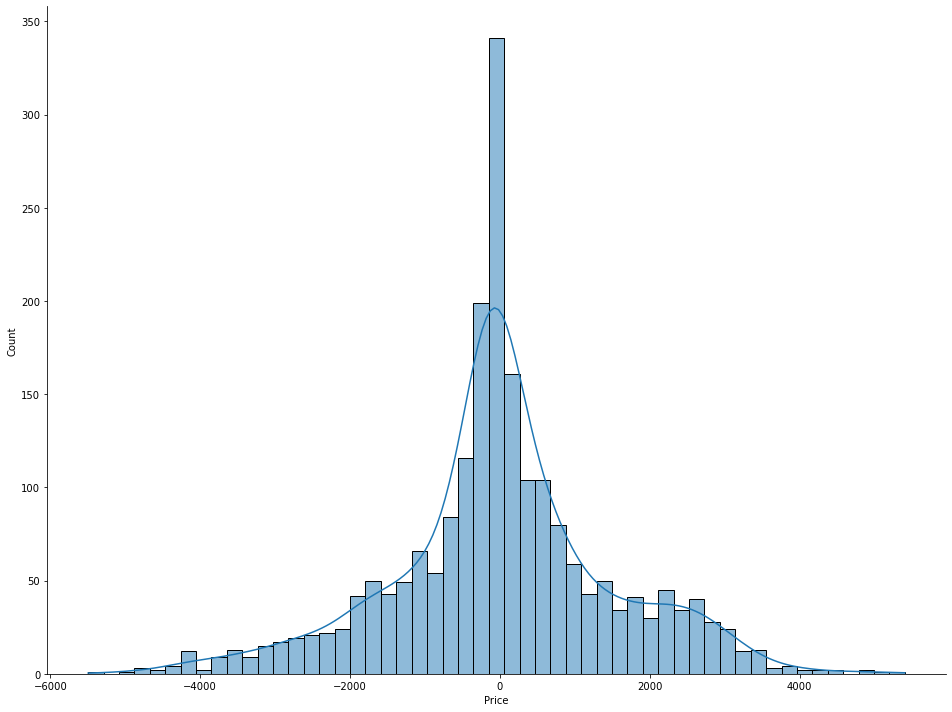

In [31]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_rf), height = 10, aspect = 8/6, kde = True)

This plot seems much closer to a normal distribution than the previous one.


We can also see the features deemed important by the model.

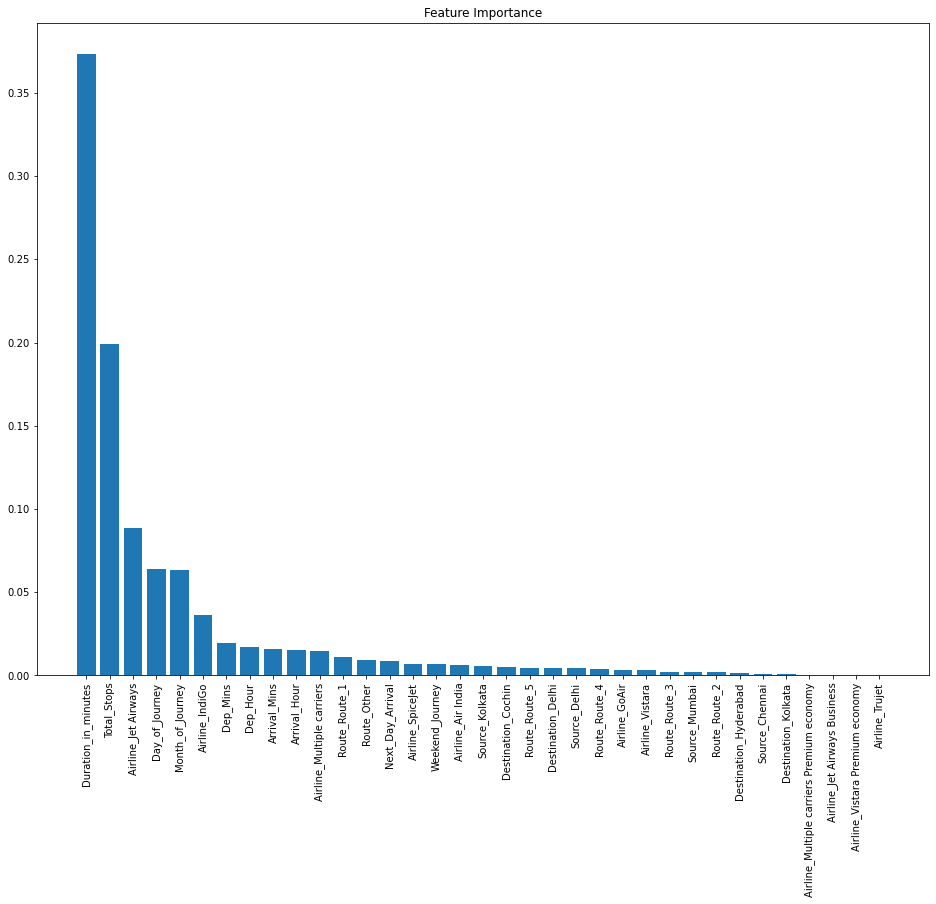

In [27]:
### PLOTTING FEATURE IMPORTANCE
importance = model_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We see that _'Duration_in_minutes'_ is still considered to be the most important but not as high as in the previous model. Unlike previously, _'Total_Stops'_ is taken as the next most significant feature, followed by _'Airline_Jet_Airways'_, _'Day_of_Journey'_ and _'Month_of_Journey'_.